In [223]:
import os 

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [224]:
!pip install transformers
!pip install tensorflow
!pip install tensorflow_addons
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [225]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow_addons.optimizers import RectifiedAdam
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [226]:
MODEL_NAME = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

model  = tf.keras.models.load_model('/content/drive/MyDrive/halla/best_model.h5'
                ,custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [227]:
def convert_data(X_data,MAX_SEQ_LEN,tokenizer):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트

    
    tokens, masks, segments, targets = [], [], [], []
    
    for X in (X_data):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
  

    return [tokens, masks, segments]


# 최고 성능의 모델 불러오기
def Processing_classification(df):


    import warnings
    warnings.filterwarnings('ignore')

    df['text_temp'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df['text_temp'].nunique()
    df.drop_duplicates(subset=['text_temp'], inplace=True)

    X_data = df['text_temp']
    MAX_SEQ_LEN = 80
    tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

    # train 데이터를 Bert의 Input 타입에 맞게 변환

    train_x= convert_data(X_data,MAX_SEQ_LEN,tokenizer)

    # print(train_x)
    predicted_value = model.predict(train_x)
    predicted_label = np.argmax(predicted_value, axis = 1)
    

    df['quarter']=0
    df['year']=0
    df['month']=0

    df=df.reset_index()

    for i in range(len(df)):

        df.loc[i,'year']=int(df.loc[i,'date'].split('.')[0])
        df.loc[i,'month']=int(df.loc[i,'date'].split('.')[1])

        tmp=df.loc[i,'date'].split('.')[1]
    
        if tmp=='01'or tmp=='02' or tmp=='03':
            df.loc[i,'quarter']=1
        elif tmp=='04'or tmp=='05' or tmp=='06':
            df.loc[i,'quarter']=2
        elif tmp=='07'or tmp=='08' or tmp=='09':
            df.loc[i,'quarter']=3
        else:
            df.loc[i,'quarter']=4

        if df.loc[i,'star_score']==100:
            df.loc[i,'star_score']=4
        elif df.loc[i,'star_score']==80:
            df.loc[i,'star_score']=3
        elif df.loc[i,'star_score']==60:
            df.loc[i,'star_score']=2
        elif df.loc[i,'star_score']==40:
            df.loc[i,'star_score']=1
        else:
            df.loc[i,'star_score']=0

    data = {
    'text':df['review'],
    'year':df['year'],
    'quarter':df['quarter'],
    'month':df['month'],
    'label_old':df['star_score'],
    'label_new':predicted_label
    }
 
    df_final = pd.DataFrame(data)
    
    print("감정분석 종료")
    return df_final

In [228]:
df=pd.read_csv('/content/drive/MyDrive/halla/danawa_kimchi.csv',encoding="CP949")
del df['Unnamed: 0']
df=df.dropna(axis=0)
df_new=Processing_classification(df)
df_new.to_csv(('/content/drive/MyDrive/halla/danawa_kimchi_result.csv'),encoding='CP949')

137/137 [==============================] - 30s 197ms/step
감정분석 종료


In [229]:
df_new

,text,year,quarter,month,label_old,label_new
0,한동안 여러번 사대부 김치 주문 고객인데 이런적 처음 이네요 우영채널이 제조사 ...,2021,2,4,0,0
1,분명 주문하며 메모란에 몇일 발송해달라고 기재했었는데근년이상 인터넷 쇼핑하며 구매자...,2022,4,11,0,0
2,사대부 김치 김치 판매한 지 꽤 오래된 걸로 알고 가끔 주문해 먹는데요 회사 사람들...,2022,3,7,0,0
3,직장과 가사일 버거워서 올 해 봄부터 김치를 구입해 먹기 시작했어요구입했던 김치 중...,2021,4,10,3,1
4,잘 받았습니다 김치국물이 약간 새어나와 스치로폼 박스안에 묻어있네요 배송이 빨랐으니...,2023,1,2,3,0
...,...,...,...,...,...,...
4371,항상재구매,2021,1,3,4,1
4372,좋아요 좋아요 좋아요 좋아,2021,1,3,3,0
4373,제품 잘 받았습니다,2021,1,3,4,1
4374,짜고 맛이 없슴다,2021,1,3,0,0


In [230]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4376 non-null   object
 1   year       4376 non-null   int64 
 2   quarter    4376 non-null   int64 
 3   month      4376 non-null   int64 
 4   label_old  4376 non-null   int64 
 5   label_new  4376 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 205.2+ KB


In [231]:
graph_year=df_new.groupby('year').size()
graph_year

year
2020    1246
2021    1281
2022    1548
2023     301
dtype: int64

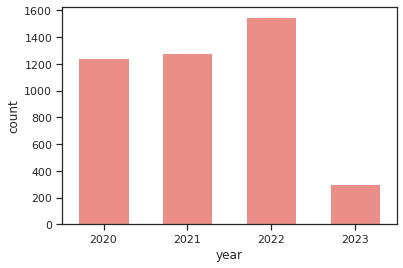

In [232]:
sns.set_theme(style="ticks")
width = 0.6
ax=sns.countplot(x=df_new['year'],color='#FC7F77')

for bar in ax.patches:
    x = bar.get_x() 
    old_width = bar.get_width() 
    bar.set_width(width) 
    bar.set_x(x+(old_width-width)/2)

In [233]:
df_new['month'].value_counts()

11    690
8     515
9     481
7     365
5     363
10    349
12    334
6     308
3     288
1     263
4     213
2     207
Name: month, dtype: int64

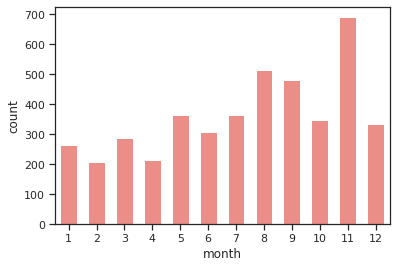

In [234]:
sns.set_theme(style="ticks")
width = 0.6
ax=sns.countplot(x=df_new['month'],color='#FC7F77')

for bar in ax.patches:
    x = bar.get_x() 
    old_width = bar.get_width() 
    bar.set_width(width) 
    bar.set_x(x+(old_width-width)/2)

In [235]:
df_new['quarter'].value_counts()

4    1373
3    1361
2     884
1     758
Name: quarter, dtype: int64

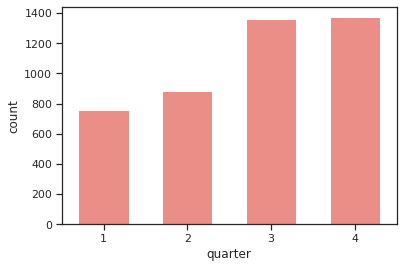

In [236]:
sns.set_theme(style="ticks")
width = 0.6
ax=sns.countplot(x=df_new['quarter'],color='#FC7F77')

for bar in ax.patches:
    x = bar.get_x() 
    old_width = bar.get_width() 
    bar.set_width(width) 
    bar.set_x(x+(old_width-width)/2)

In [237]:
df_group1 = df_new.groupby(['year', 'quarter'])['label_new'].apply(lambda x: pd.Series([(x == 0).sum(), (x == 1).sum()])).reset_index()
df_group1.rename(columns={'level_2':'PN','label_new':'value'},inplace=True)
df_group1

,year,quarter,PN,value
0,2020,1,0,12
1,2020,1,1,48
2,2020,2,0,59
3,2020,2,1,310
4,2020,3,0,111
5,2020,3,1,367
6,2020,4,0,55
7,2020,4,1,284
8,2021,1,0,15
9,2021,1,1,107


In [287]:
df_1=df_new.groupby(['year','quarter']).count().reset_index()
del df_1['text']
del df_1['month']
del df_1['label_old']
df_1

,year,quarter,label_new
0,2020,1,60
1,2020,2,369
2,2020,3,478
3,2020,4,339
4,2021,1,122
5,2021,2,216
6,2021,3,419
7,2021,4,524
8,2022,1,275
9,2022,2,299


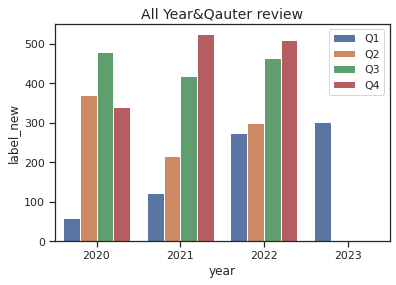

In [288]:
sns.set_theme(style="ticks")
plt.title('All Year&Qauter review', fontsize=14)
ax=sns.barplot(data=df_1,x='year',y='label_new',hue='quarter',ci=None)
ax.legend(['Q1','Q2','Q3','Q4'],loc='upper right')
plt.show()

In [320]:
df_2=df_group1.groupby(['year','PN']).sum().reset_index()
del df_2['quarter']
df_2

,year,PN,value
0,2020,0,237
1,2020,1,1009
2,2021,0,225
3,2021,1,1056
4,2022,0,264
5,2022,1,1284
6,2023,0,45
7,2023,1,256


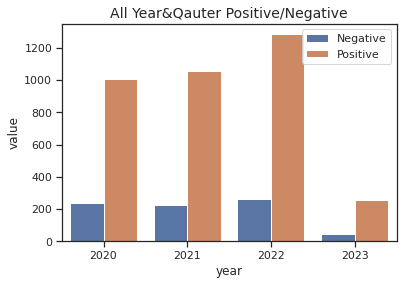

In [321]:
sns.set_theme(style="ticks")
plt.title('All Year&Qauter Positive/Negative', fontsize=14)
ax=sns.barplot(data=df_2,x='year',y='value',hue='PN',ci=None)
ax.legend(['Negative','Positive'],loc='upper right')
plt.show()

In [271]:
df_3=df_group1.groupby('year').sum().reset_index()
df_3

,year,quarter,PN,value
0,2020,20,4,1246
1,2021,20,4,1281
2,2022,20,4,1548
3,2023,2,1,301


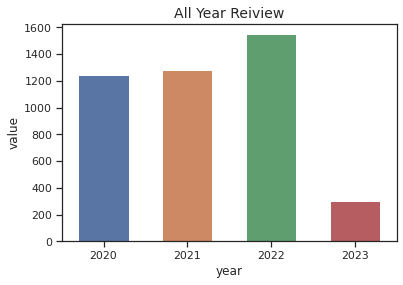

In [275]:
sns.set_theme(style="ticks")
width = 0.6
plt.title('All Year Reiview', fontsize=14)
ax=sns.barplot(data=df_3,x='year',y='value',ci=None)

for bar in ax.patches:
    x = bar.get_x() 
    old_width = bar.get_width() 
    bar.set_width(width) 
    bar.set_x(x+(old_width-width)/2)

plt.show()